In [1]:
from os import environ

from pyspark.sql import SparkSession

environ[
    'PYSPARK_PYTHON'] = "/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/venv/bin/python"
session = SparkSession.builder \
    .master("yarn") \
    .appName("web-archive-query-log-query-length") \
    .config("spark.executor.instances", 3) \
    .getOrCreate()

In [2]:
sc = session.sparkContext
sc

<SparkContext master=yarn appName=web-archive-query-log-query-length>

In [3]:
stop_words = [
    # "茅聵驴茅聡聦猫聹聵猫聸聸忙卤",
    # "é\x98¿é\x87\x8cè\x9c\x98è\x9b\x9bæ±",
]

In [4]:
from pathlib import Path

global_data_dir = Path("/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/")
global_data_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log')

In [5]:
data_dir = global_data_dir / "focused"
data_dir

PosixPath('/mnt/ceph/storage/data-in-progress/data-research/web-search/web-archive-query-log/focused')

In [6]:
from pathlib import Path

figures_dir = Path("figures")
figures_dir.mkdir(parents=True, exist_ok=True)

In [7]:
def paths_jsonl(service: str, base_type: str):
    base_path = data_dir / base_type / service
    if not base_path.exists():
        return []
    yield from base_path.glob("*/*.jsonl.gz")

In [8]:
from json import loads, JSONDecodeError
from typing import Iterator
from gzip import GzipFile

def read_jsonl(path: Path) -> Iterator:
    print(f"Read JSONL records in {path}.")
    try:
        with GzipFile(path, "r") as gzip_file:
            for line in gzip_file:
                try:
                    url = loads(line)
                except JSONDecodeError:
                    continue
                yield url
    except:
        raise
        return 

In [9]:
from typing import Optional


def detect_language(text: str) -> Optional[str]:
    text = text.replace("\n", " ")
    # if len(text) < 10:
    #     return None
    from cld3 import get_language
    language_prediction = get_language(text)
    if language_prediction is None:
        return None
    return language_prediction.language.split("-")[0] if language_prediction.is_reliable else None

In [10]:
def group_key(service_query: tuple) -> tuple:
    service, query = service_query
    query_text = query["query"]
    language = detect_language(query_text)
    return service, language, len(query_text)

In [11]:
with Path("services.txt").open("rt") as file:
    alexa_services = [
        line.strip()
        for line in file
        if line
    ]
len(alexa_services)

1087

In [12]:
from json import loads
from pandas import DataFrame
from datetime import datetime

counts = sc.parallelize(alexa_services, 1000)\
    .keyBy(lambda service: service)\
    .flatMapValues(lambda service: paths_jsonl(service, "archived-query-urls"))\
    .repartition(10_000)\
    .flatMapValues(read_jsonl)\
    .keyBy(group_key)\
    .countByKey()

In [13]:
len(counts)

450647

In [83]:
df = DataFrame([
    {
        "service": service,
        "language": language,
        "query_length": query_length,
        "count": count,
    }
    for (service, language, query_length), count in counts.items()
])
df.to_csv("query-length-counts.csv")
df

,service,language,query_length,count
0,wikimedia,en,32,654
1,wikimedia,None,9,3665
2,wikimedia,None,13,6724
3,wikimedia,it,26,67
4,wikimedia,sv,12,155
...,...,...,...,...
450642,wikimedia,ceb,46,1
450643,wikimedia,bs,1,1
450644,wikimedia,da,55,2
450645,wikimedia,sq,5,1


In [88]:
top_services = df.groupby("service")["count"].sum().sort_values(ascending=False).head(5).index
#     "google",
#     "youtube",
#     "baidu",
#     "qq",
#     "facebook",
# ]
top_services

Index(['google', 'baidu', 'twitter', 'youtube', 'stackoverflow'], dtype='object', name='service')

In [110]:
service_names = {
    "google": "Google",
    "youtube": "YouTube",
    "baidu": "Baidu",
    "qq": "QQ",
    "facebook": "Facebook",
    "twitter": "Twitter",
    "stackoverflow": "StackOverflow",
    "others": "others",
}

In [111]:
service_colors = {
    "google": "#4285f4",
    "youtube": "#ff0000",
    "baidu": "#de0f17",
    "qq": "#0052d4",
    "facebook": "#1877f2",
    "twitter": "#1da1f2",
    "stackoverflow": "#f48024",
}

In [112]:
top_services_names = [service_names.get(service, None) for service in top_services] + ["others"]
top_services_colors = [service_colors.get(service, None) for service in top_services] + ["#646464"]

In [113]:
df_plot = df.copy()
df_plot.loc[
    ~df_plot["service"].isin(list(top_services)),
    "service"
] = "others"
df_plot["service"] = df_plot["service"].map(service_names, na_action=None)
df_plot = df_plot.groupby([
    "service", 
    "query_length",
])["count"].sum().reset_index()
df_plot

,service,query_length,count
0,Baidu,0,90
1,Baidu,1,9723
2,Baidu,2,1213140
3,Baidu,3,1398569
4,Baidu,4,2066450
...,...,...,...
5325,others,3640,1
5326,others,3797,1
5327,others,5000,1
5328,others,5089,1


<Figure size 640x480 with 0 Axes>

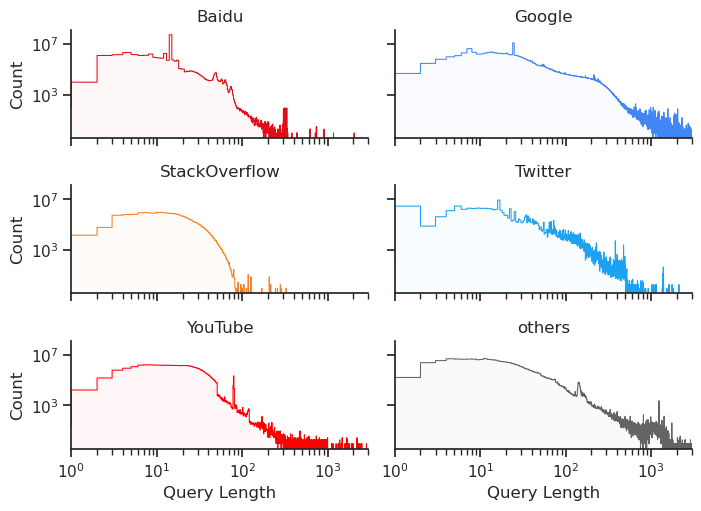

In [115]:
from seaborn import histplot, FacetGrid, color_palette, kdeplot, displot, set_theme, set_style, move_legend
from matplotlib.pyplot import tight_layout, axhline

width = 3.5
aspect = 2
set_theme()
tight_layout()
set_style("ticks")
plot = FacetGrid(
    data=df_plot,
    col="service",
    col_wrap=2,
    hue="service",
    hue_order=top_services_names,
    # palette="bright",
    palette=top_services_colors,
    aspect=aspect,
    height=width/aspect,
    sharex=True,
    sharey=True,
)
plot.map_dataframe(
    histplot,
    x="query_length",
    weights="count",
    element="step",
    binwidth=1,
    multiple="layer",
    linewidth=0.75,
    alpha=0.03,
    # multiple="stack",
    # linewidth=0layer', 'stack', 'fill', 'dodge,
    # alpha=0.5,
    # multiple="fill",
    # multiple="dodge",
    # linewidth=0.75,
    # alpha=0.03,
)
plot.set(
    xlim=(1, 3000),
)
plot.set_titles("{col_name}")
plot.set_axis_labels("Query Length", "Count")
# plot.set_axis_labels("", "")
# move_legend(
#     plot,
#     title="",
#     loc="upper right",
#     bbox_to_anchor=(0.8, 0.9),
# )
plot.set(
    yscale="log", 
    xscale="log",
)
# plot.despine(left=True)
plot.savefig("figures/plot-query-length-histogram-facet.pdf")
plot.savefig("figures/plot-query-length-histogram-facet.png")
plot

In [131]:
def sample_queries(query_length: int, samples: int) -> list:
    rdd = sc.parallelize(alexa_services, 1000)\
        .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
        .repartition(10_000)\
        .flatMap(read_jsonl)\
        .map(lambda url: url["query"])\
        .filter(lambda query: len(query) == query_length)\
    length = rdd.count()
    return rdd.sample(False, samples / length).collect()

In [134]:
for q in sample_queries(5, 10):
    print(q.replace("\n", "<NEWLINE>"))

フンボルト
长袖衬衫男
talvi
video
大规模删帖
query
query
merry
blind
#mock
#wsop
query
r2 d2
v2ray
"李思宇"


In [135]:
for q in sample_queries(10, 10):
    print(q.replace("\n", "<NEWLINE>"))

comic font
hx-yun.net
comic sans
#чемпионат
#co_health
카이리 어빙 농구화
real-me-c2
waterscape
2015+anime


In [136]:
for q in sample_queries(100, 10):
    print(q.replace("\n", "<NEWLINE>"))

Priscilla's room Wilson, Louise Latham. old catalog priscillasroom00wils haswbstatement:P31=Q3331189
isabelle_(animal_crossing) animated order:score tailwag anthro -2d_animation video_games -yellow_fur
related:https://www3.ntu.edu.sg/home/ehchua/programming/java/J9c_PackageClasspath.html javac package
related:https://www.wsj.com/articles/SB10001424127887323335404578444792065046344 china is capitalist
Moravcsik, Edith. 2003. A semantic analysis of associative plurals. Studies in Language 27. 469–503.
Merging Parametric Active Contours Within Homogeneous Image Regions for MRI-Based Lung Segmentation.
Best-Artificial-Grass-For-Balcony-Or-DoormatSoft-And-Durable-Plastic-Turf-Carpet-MatArtificial-Grass
banarasi-silk-works-party-wear-designer-blue---black-colour-cotton-combo-saree-for-women-s-bsw39_40-
#%e3%83%94%e3%83%a9%e3%83%86%e3%82%a3%e3%82%b9%e3%82%b9%e3%82%bf%e3%82%b8%e3%82%aa%e3%82%b5%e3%82%a4


In [137]:
for q in sample_queries(1000, 10):
    print(q.replace("\n", "<NEWLINE>"))

Bidrag till kännedom av Finlands natur och folk <NEWLINE><NEWLINE><NEWLINE>Axel Olai Heikel<NEWLINE>&nbsp;(1851&ndash;1924)&nbsp;&nbsp;<NEWLINE><NEWLINE><NEWLINE>|class=photo<NEWLINE><NEWLINE><NEWLINE>Description<NEWLINE>Finnish archaeologist and ethnologist<NEWLINE><NEWLINE>Date of birth/death<NEWLINE><NEWLINE>28 April 1851&nbsp;<NEWLINE>6 September 1924&nbsp;<NEWLINE><NEWLINE>Location of birth/death<NEWLINE><NEWLINE>Turku and Pori Province<NEWLINE>Helsinki<NEWLINE><NEWLINE>Authority control<NEWLINE><NEWLINE>*: Q2619687<NEWLINE>*VIAF:&thinsp;18146826<NEWLINE>*ISNI:&thinsp;0000 0000 8339 6178<NEWLINE>*LCCN:&thinsp;no2004045023<NEWLINE>*Open Library:&thinsp;OL2296918A<NEWLINE>*GND:&thinsp;124039251<NEWLINE>*WorldCat<NEWLINE><NEWLINE><NEWLINE><NEWLINE><NEWLINE><NEWLINE><NEWLINE><NEWLINE><NEWLINE><NEWLINE><NEWLINE>Anders Anton von Stiernman<NEWLINE>&nbsp;(1695&ndash;1765)&nbsp;<NEWLINE><NEWLINE><NEWLINE>|class=photo<NEWLINE><NEWLINE><NEWLINE>Description<NEWLINE>Swedish historian, public r

In [138]:
num_languages = sc.parallelize(alexa_services, 1000)\
    .flatMap(lambda service: paths_jsonl(service, "archived-query-urls"))\
    .repartition(10_000)\
    .flatMap(read_jsonl)\
    .map(lambda url: url["query"])\
    .map(detect_language)\
    .distinct()\
    .count()
num_languages

104